
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## SWAN simulations

inputs required: 
  * Sea and swell selected cases from ***Notebook 02_01***

in this notebook:
  * SWAN mesh descriptions
  * SWAN simulations for sea and swell conditions
  * Read and store SWAN output at the location of study


### Workflow:

<div>
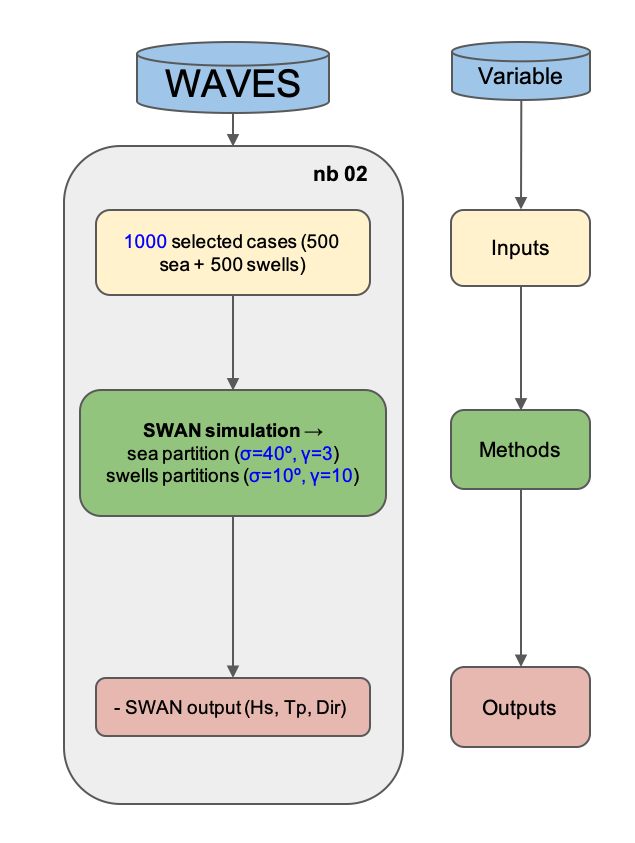
</div>




The SWAN model allows to simulate the wave propagation in nearshore areas (Booij et al., 1999). The design points from notebook 02_01 provide the boundary conditions for a series of simulations from the SWAN model. SWAN was run in stationary mode. Sea and Swell conditions have been simulated independently and summed linearly afterwards. 

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database

# TODO: add to README, add package to requirements, use packaged ant not dev
sys.path.insert(0, '/Users/nico/Projects/BlueMath/mw_deltares/mw_deltares')

# mw_deltares custom toolbox
from swan.wrap import SwanProject, SwanWrap_STAT
from swan.plots.stat import scatter_maps



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# SWAN projects folder and bathymetry files
p_swan = db.paths.site.NEARSHORE.swan_projects
p_swan_ext = op.join(p_swan, 'Roinamur_ext_bottom.dat')
p_swan_int = op.join(p_swan, 'Roinamur_int_bottom.dat')

#  shore (for plots)
p_shore = op.join(p_swan, 'shore.npy')
np_shore = np.load(p_shore)

# load sets of waves for SWAN scenarios
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()


# paths for output storage
p_out_sea_mesh_main  = op.join(p_swan, 'out_sea_mesh_main.nc')
p_out_sea_mesh_nest1 = op.join(p_swan, 'out_sea_mesh_nest1.nc')

p_out_swl_mesh_main  = op.join(p_swan, 'out_swl_mesh_main.nc')
p_out_swl_mesh_nest1 = op.join(p_swan, 'out_swl_mesh_nest1.nc')



## SWAN: main and nested grid descriptions

In [3]:
main_grid = {
    'xpc': 166.6159,  # x origin
    'ypc': 8.4105,    # y origin
    'alpc': 0,        # x-axis direction 
    'xlenc': 1.3722,  # grid length in x
    'ylenc': 1.175,   # grid length in y
    'mxc': 137,       # number mesh x
    'myc': 118,       # number mesh y
    'dxinp': 0.01,    # size mesh x
    'dyinp': 0.01,    # size mesh y
}

nested_grid = {
    'xpc': 167.4059,
    'ypc': 9.3505,
    'alpc': 0,
    'xlenc': 0.12,
    'ylenc': 0.08,
    'mxc': 120,
    'myc': 80,
    'dxinp': 0.001,
    'dyinp': 0.001,
}



## SWAN: Build and launch SEA waves project

In [4]:
# waves data hs and spr
wvs_sea_subset['hs'] = 1
wvs_sea_subset['spr'] = 40
wvs_sea_subset.rename(columns={'tp':'per'}, inplace=True)  # rename Tp for swan wrapper


# swan project
sp = SwanProject(p_swan, 'sea')

# main mesh: depth and computational grid 
sp.mesh_main.dg = main_grid.copy()
sp.mesh_main.cg = main_grid.copy()
sp.mesh_main.depth = np.loadtxt(p_swan_ext)

# nested mesh: depth and computational grid 
sp.mesh_nest1.dg = nested_grid.copy()
sp.mesh_nest1.cg = nested_grid.copy()
sp.mesh_nest1.depth = np.loadtxt(p_swan_int)

# activate nested mesh
sp.run_nest1 = True


# SWAN parameters 
sp.params = {
    'sea_level': 0,
    'jonswap_gamma': 3,
    'coords_spherical': 'CCM',
    'waves_period': 'PEAK',
    'nested_bounds': 'CLOSED',
}

    
# SWAN project wrapper
sw = SwanWrap_STAT(sp)

# build and launch cases
#sw.build_cases(wvs_sea_subset)
#sw.run_cases()


<xarray.Dataset>
Dimensions:  (case: 500, lat: 118, lon: 137)
Coordinates:
  * lat      (lat) float64 8.411 8.42 8.43 8.44 8.45 ... 9.546 9.556 9.566 9.576
  * lon      (lon) float64 166.6 166.6 166.6 166.6 ... 167.9 168.0 168.0 168.0
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 0.8015722 0.8013627 ... 1.0091549 1.008814
    Tm02     (case, lon, lat) float32 17.288624 17.286337 ... 10.432361
    Dir      (case, lon, lat) float32 98.23924 98.24765 ... 122.95314 122.906586
    Dspr     (case, lon, lat) float32 33.649094 33.700153 ... 39.174484 39.12939
    TPsmoo   (case, lon, lat) float32 22.788242 22.787281 ... 13.242727


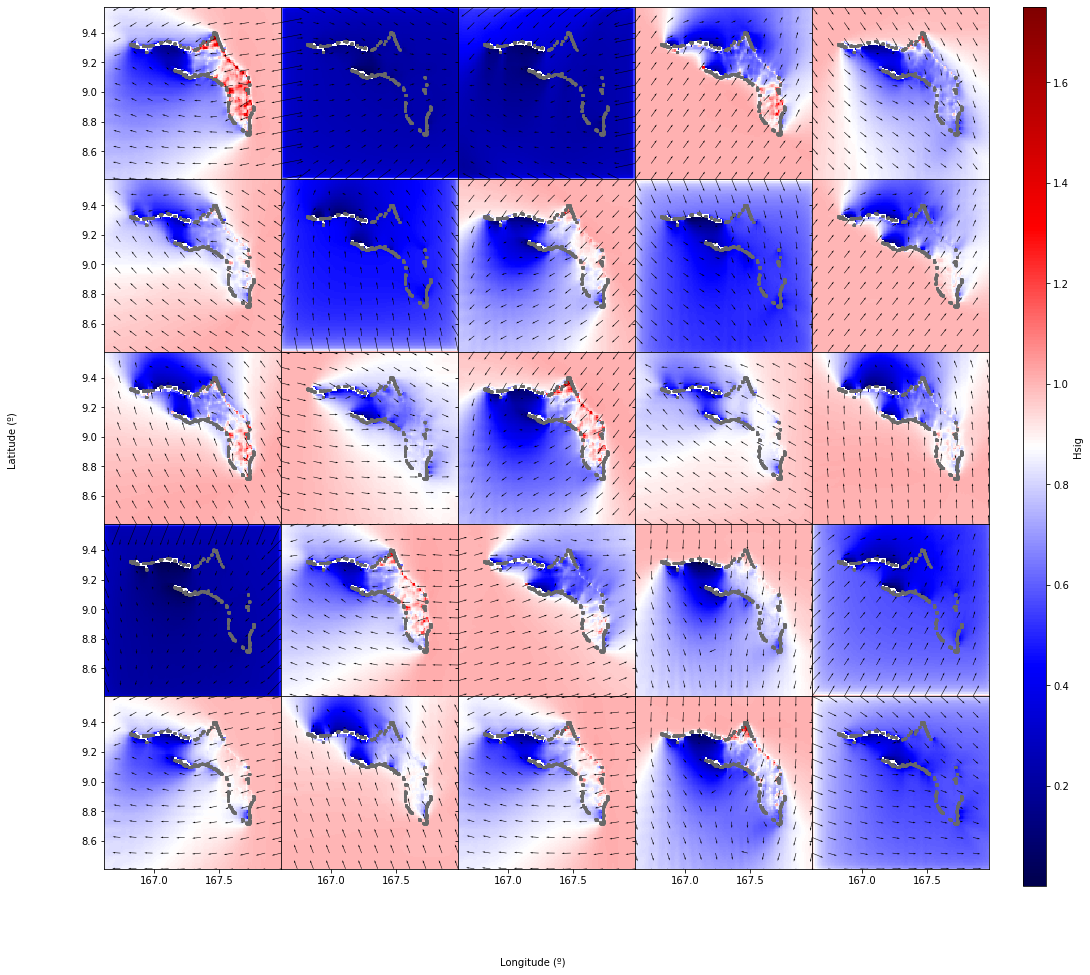

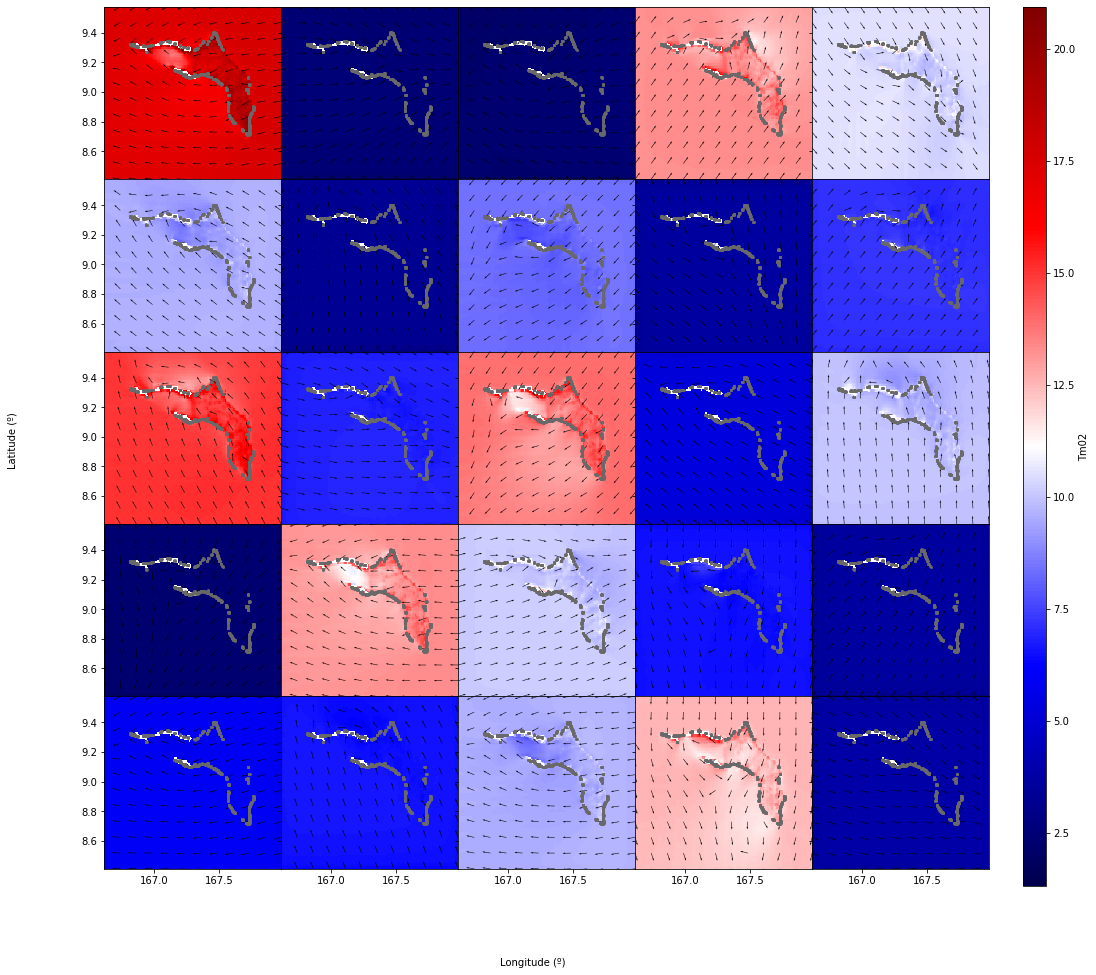

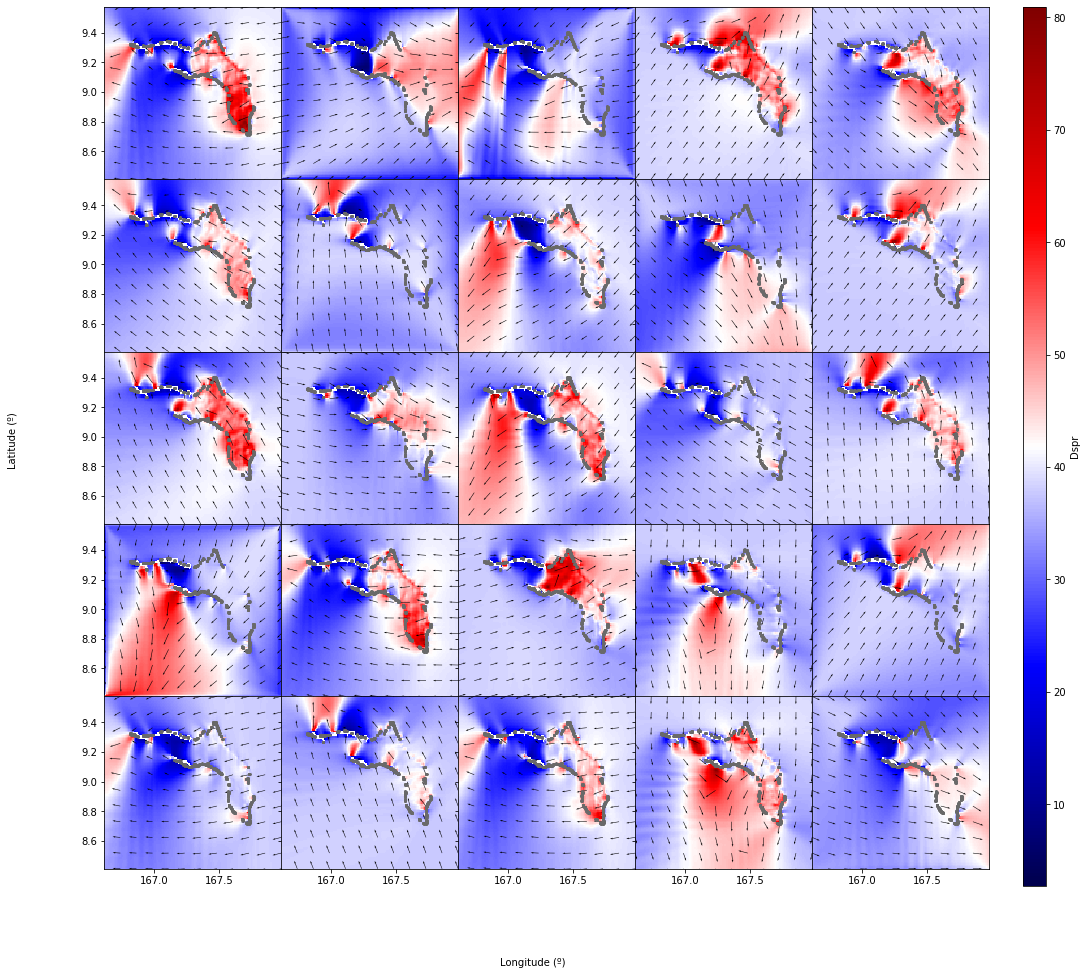

In [5]:
# extract output for main mesh
out_sea_mm = sw.extract_output()
out_sea_mm.to_netcdf(p_out_sea_mesh_main)
print(out_sea_mm)

# plot scatter maps
scatter_maps(out_sea_mm, n_cases=25, np_shore=np_shore);


<xarray.Dataset>
Dimensions:  (case: 500, lat: 80, lon: 120)
Coordinates:
  * lat      (lat) float64 9.351 9.351 9.353 9.354 ... 9.427 9.428 9.429 9.43
  * lon      (lon) float64 167.4 167.4 167.4 167.4 ... 167.5 167.5 167.5 167.5
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 0.58000845 0.5218513 ... 0.130353
    Tm02     (case, lon, lat) float32 17.195349 16.468441 ... 10.35636 8.975017
    Dir      (case, lon, lat) float32 60.640045 52.836685 ... 198.07407
    Dspr     (case, lon, lat) float32 45.739502 45.905403 ... 13.335572
    TPsmoo   (case, lon, lat) float32 22.651564 22.613562 ... 13.074024


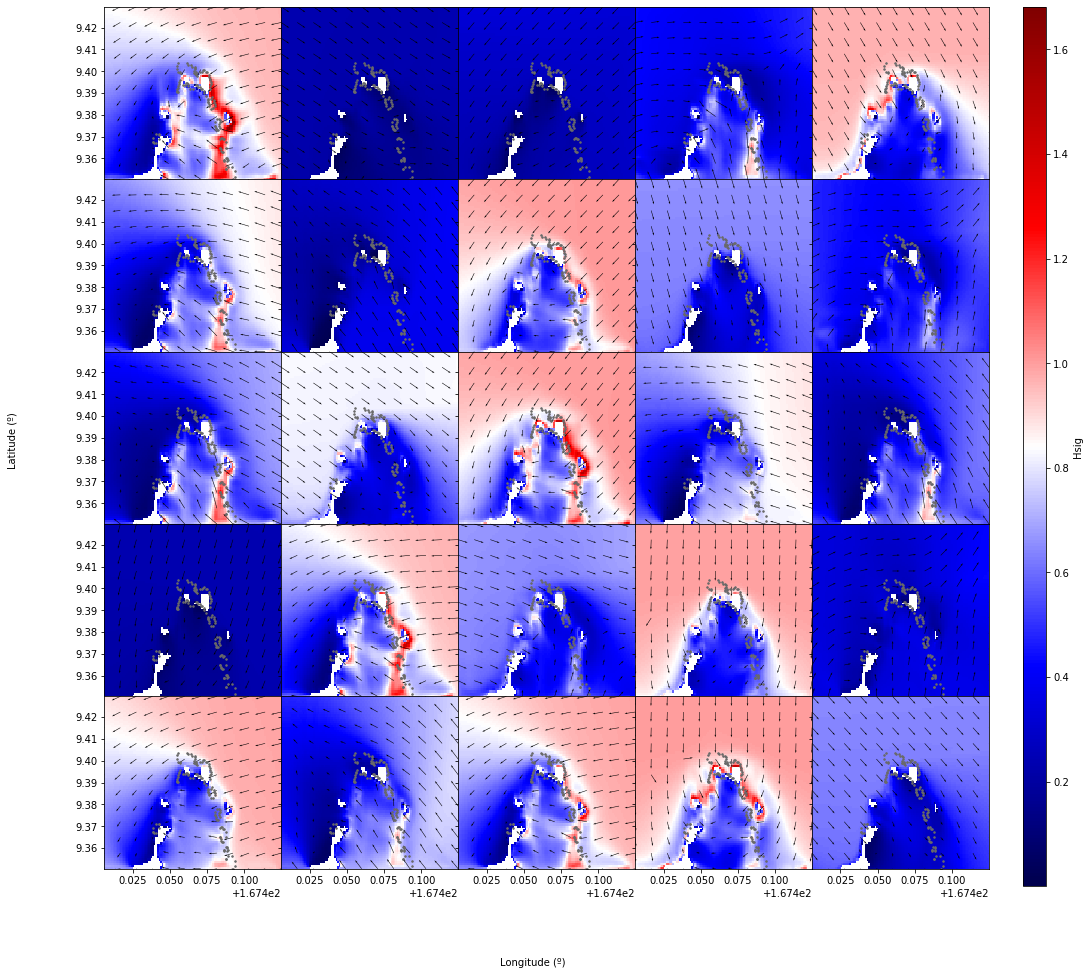

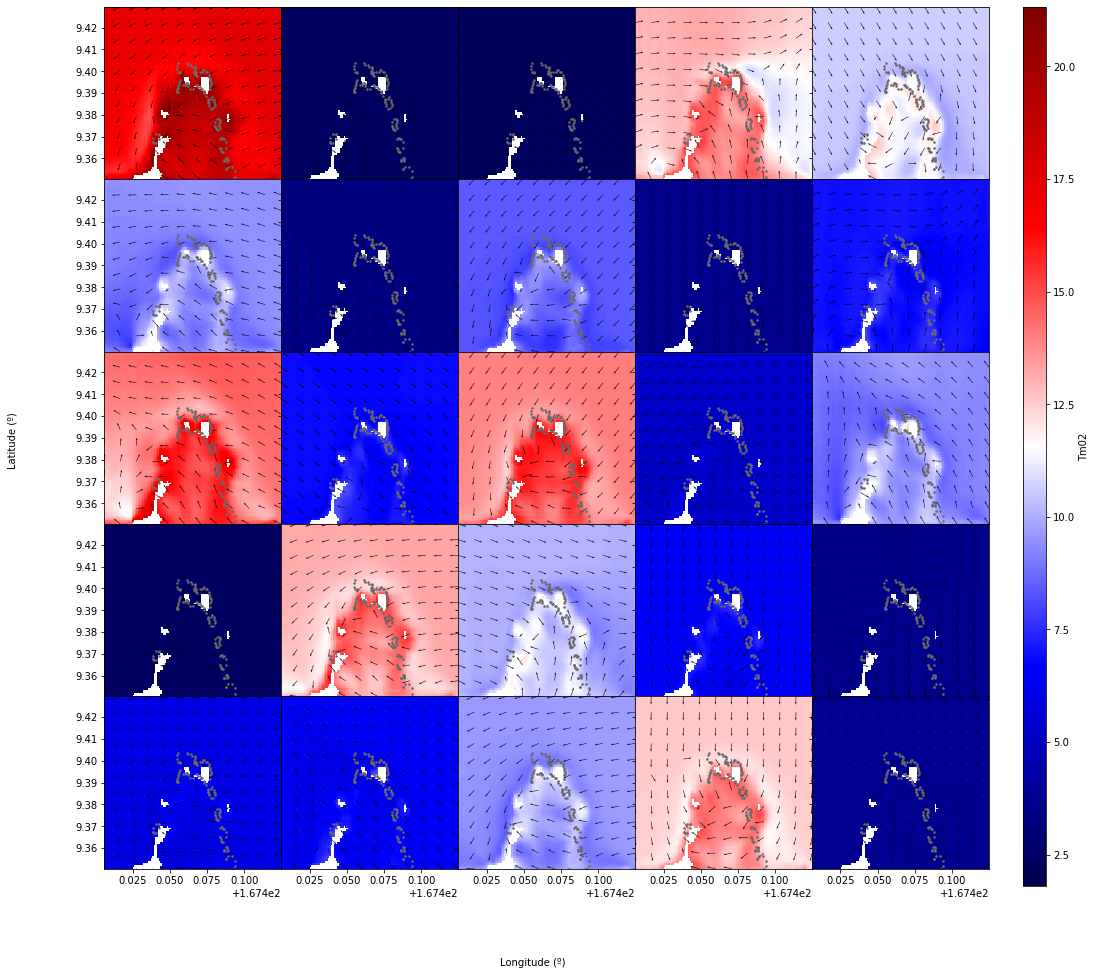

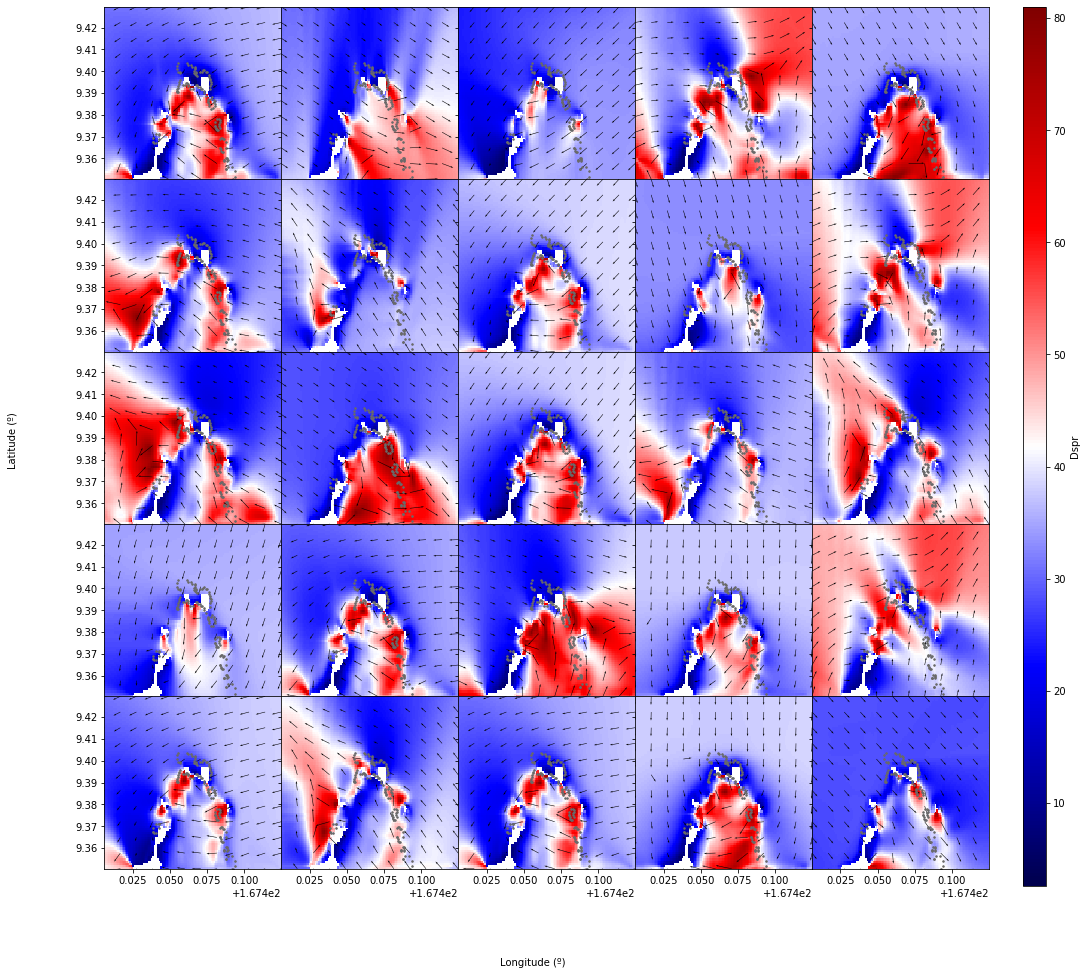

In [6]:
# extract output for nested mesh
out_sea_mn1 = sw.extract_output(mesh=sp.mesh_nest1)
out_sea_mn1.to_netcdf(p_out_sea_mesh_nest1)
print(out_sea_mn1)

# plot scatter maps
scatter_maps(out_sea_mn1, n_cases=25, np_shore=np_shore);



## SWAN: Build and launch SWELL waves project

In [7]:
# waves data hs and spr
wvs_swell_subset['hs'] = 1
wvs_swell_subset['spr'] = 10
wvs_swell_subset.rename(columns={'tp':'per'}, inplace=True)  # rename Tp for swan wrapper


# swan project
sp = SwanProject(p_swan, 'swell')

# main mesh: depth and computational grid 
sp.mesh_main.dg = main_grid.copy()
sp.mesh_main.cg = main_grid.copy()
sp.mesh_main.depth = np.loadtxt(p_swan_ext)

# nested mesh: depth and computational grid 
sp.mesh_nest1.dg = nested_grid.copy()
sp.mesh_nest1.cg = nested_grid.copy()
sp.mesh_nest1.depth = np.loadtxt(p_swan_int)

# activate nested mesh
sp.run_nest1 = True


# SWAN parameters 
sp.params = {
    'sea_level': 0,
    'jonswap_gamma': 10,
    'coords_spherical': 'CCM',
    'waves_period': 'PEAK',
    'nested_bounds': 'CLOSED',
}

    
# SWAN project wrapper
sw = SwanWrap_STAT(sp)

# build and launch cases
#sw.build_cases(wvs_swell_subset)
#sw.run_cases()


<xarray.Dataset>
Dimensions:  (case: 500, lat: 118, lon: 137)
Coordinates:
  * lat      (lat) float64 8.411 8.42 8.43 8.44 8.45 ... 9.546 9.556 9.566 9.576
  * lon      (lon) float64 166.6 166.6 166.6 166.6 ... 167.9 168.0 168.0 168.0
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 0.9510986 0.95267385 ... 0.9946909
    Tm02     (case, lon, lat) float32 21.030333 21.031511 ... 4.2471313
    Dir      (case, lon, lat) float32 358.1951 358.29395 ... 301.10138 301.0382
    Dspr     (case, lon, lat) float32 14.070292 14.239314 ... 10.455374
    TPsmoo   (case, lon, lat) float32 24.381254 24.38075 ... 4.9284143 4.9278545


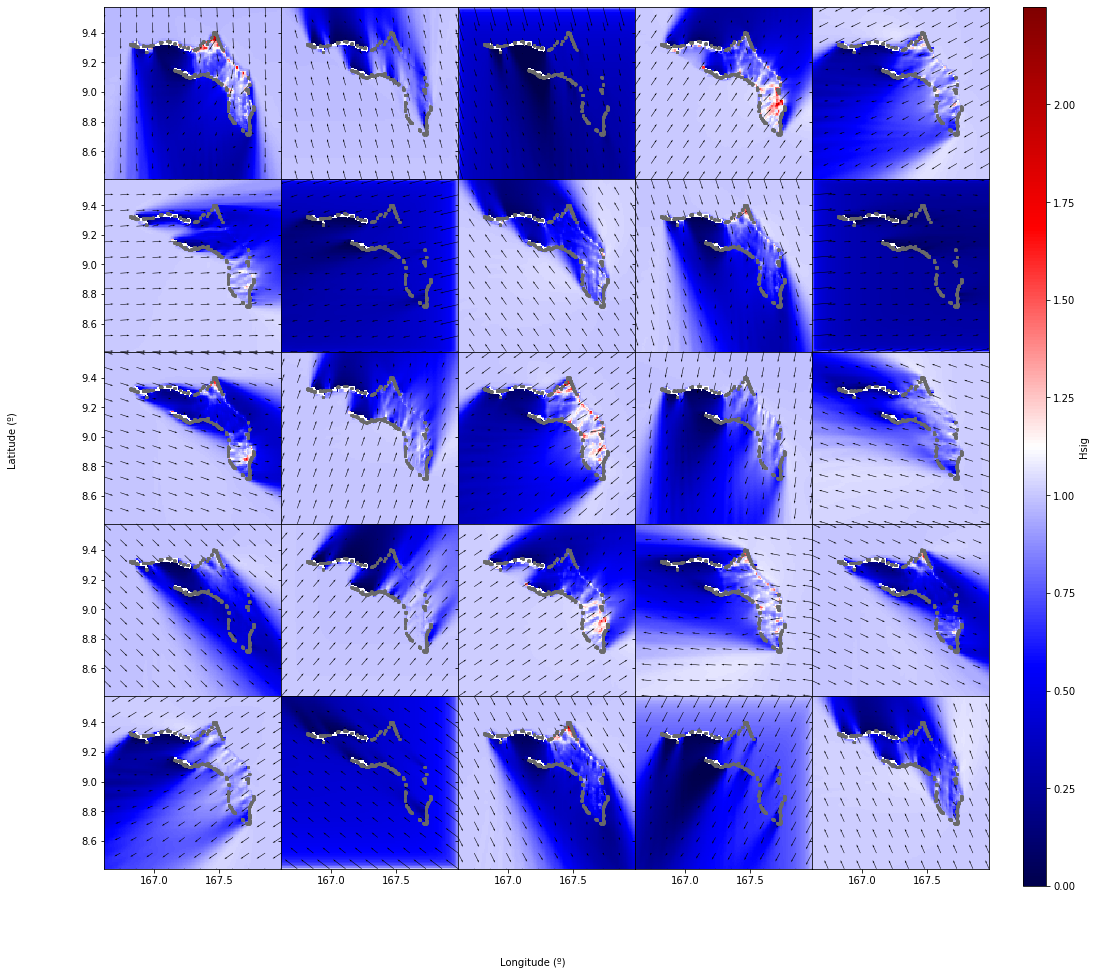

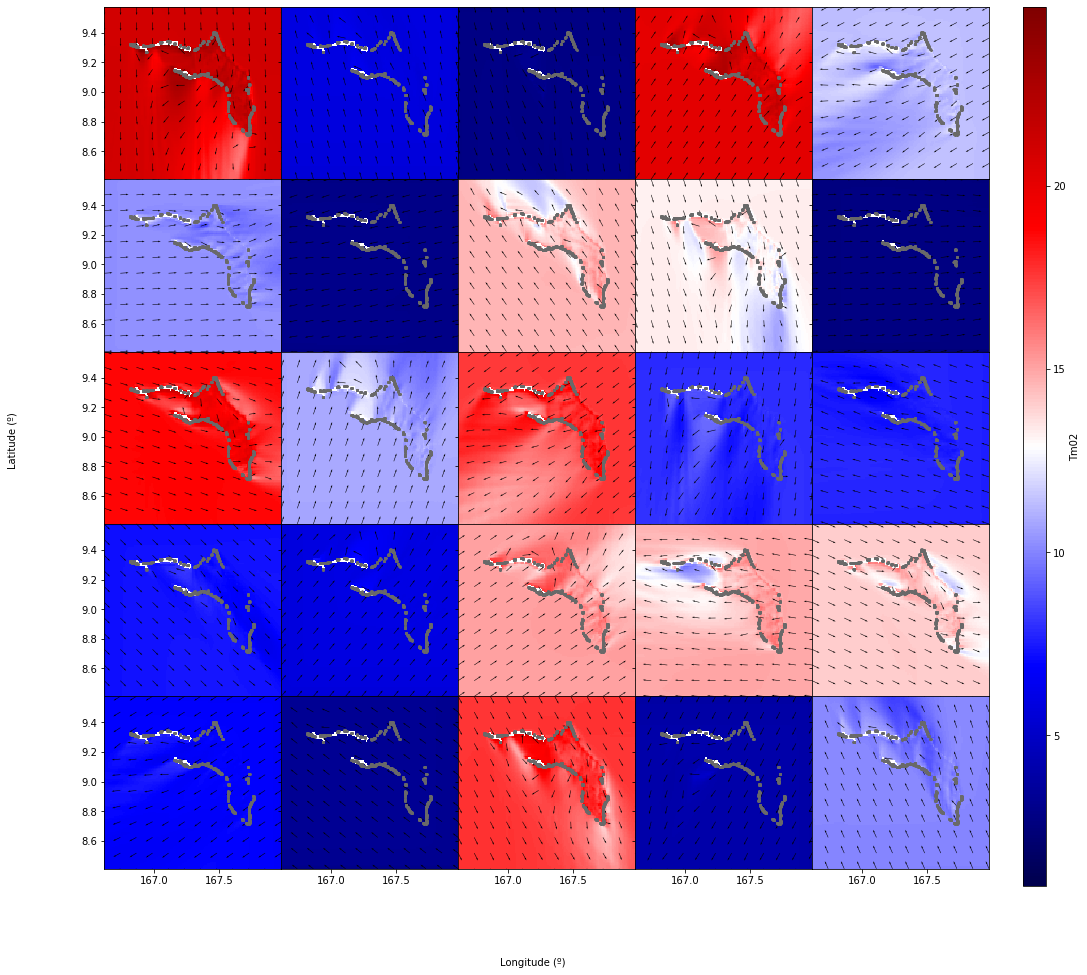

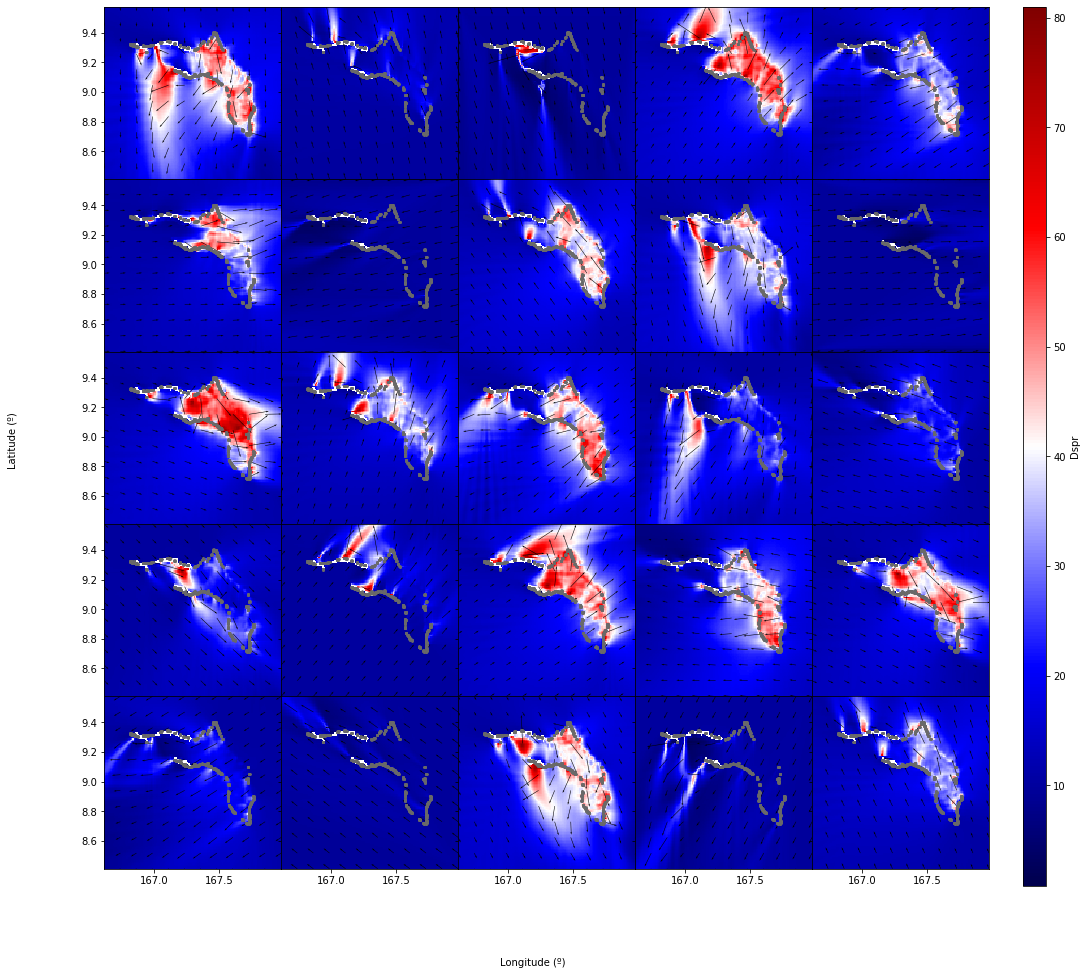

In [8]:
# extract output for main mesh
out_swl_mm = sw.extract_output()
out_swl_mm.to_netcdf(p_out_swl_mesh_main)
print(out_swl_mm)

# plot scatter maps
scatter_maps(out_swl_mm, n_cases=25, np_shore=np_shore);


<xarray.Dataset>
Dimensions:  (case: 500, lat: 80, lon: 120)
Coordinates:
  * lat      (lat) float64 9.351 9.351 9.353 9.354 ... 9.427 9.428 9.429 9.43
  * lon      (lon) float64 167.4 167.4 167.4 167.4 ... 167.5 167.5 167.5 167.5
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 0.9163837 0.88718456 ... 0.05617285
    Tm02     (case, lon, lat) float32 21.566992 21.385366 ... 4.8932447
    Dir      (case, lon, lat) float32 1.5211487 359.60764 ... 299.7879 229.18137
    Dspr     (case, lon, lat) float32 24.875357 21.45971 ... 11.156504 17.993298
    TPsmoo   (case, lon, lat) float32 24.565804 24.54061 ... 5.0155745 5.0367026


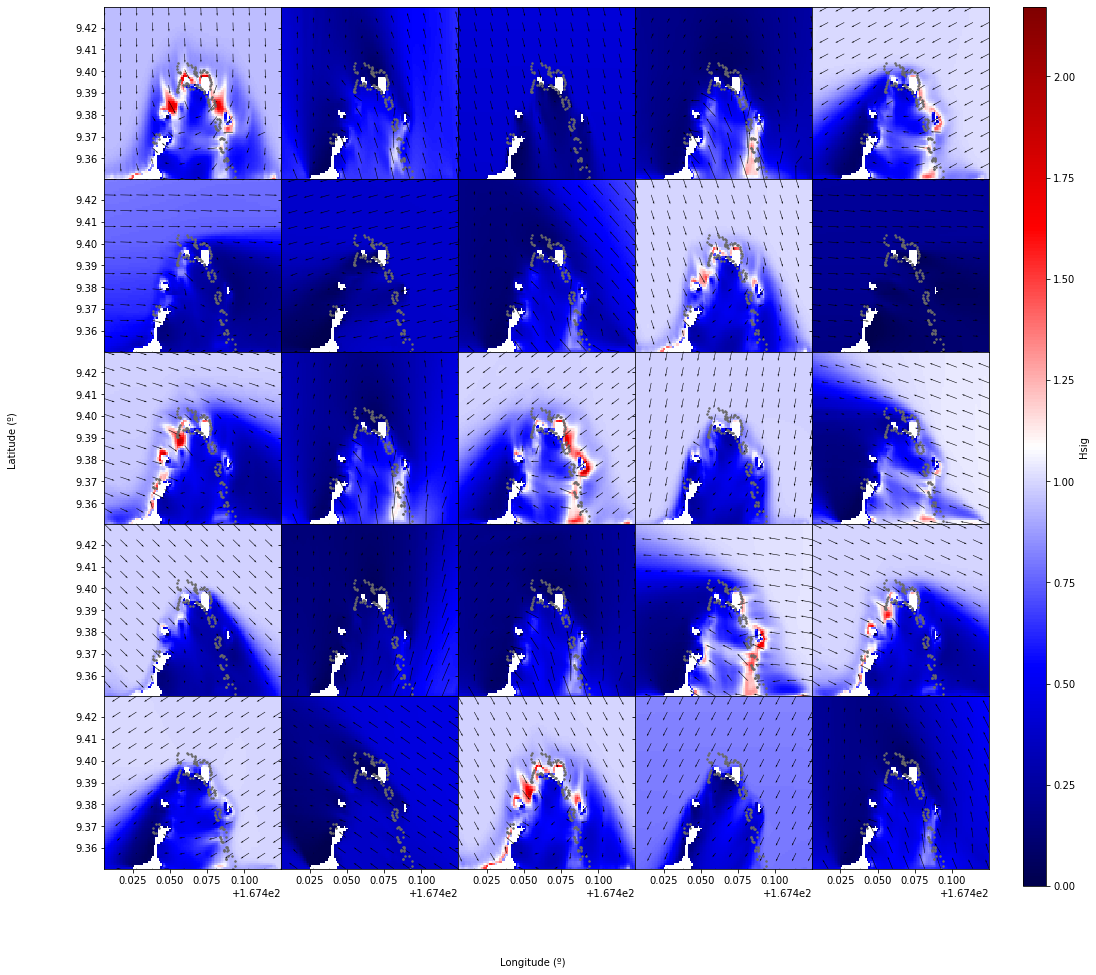

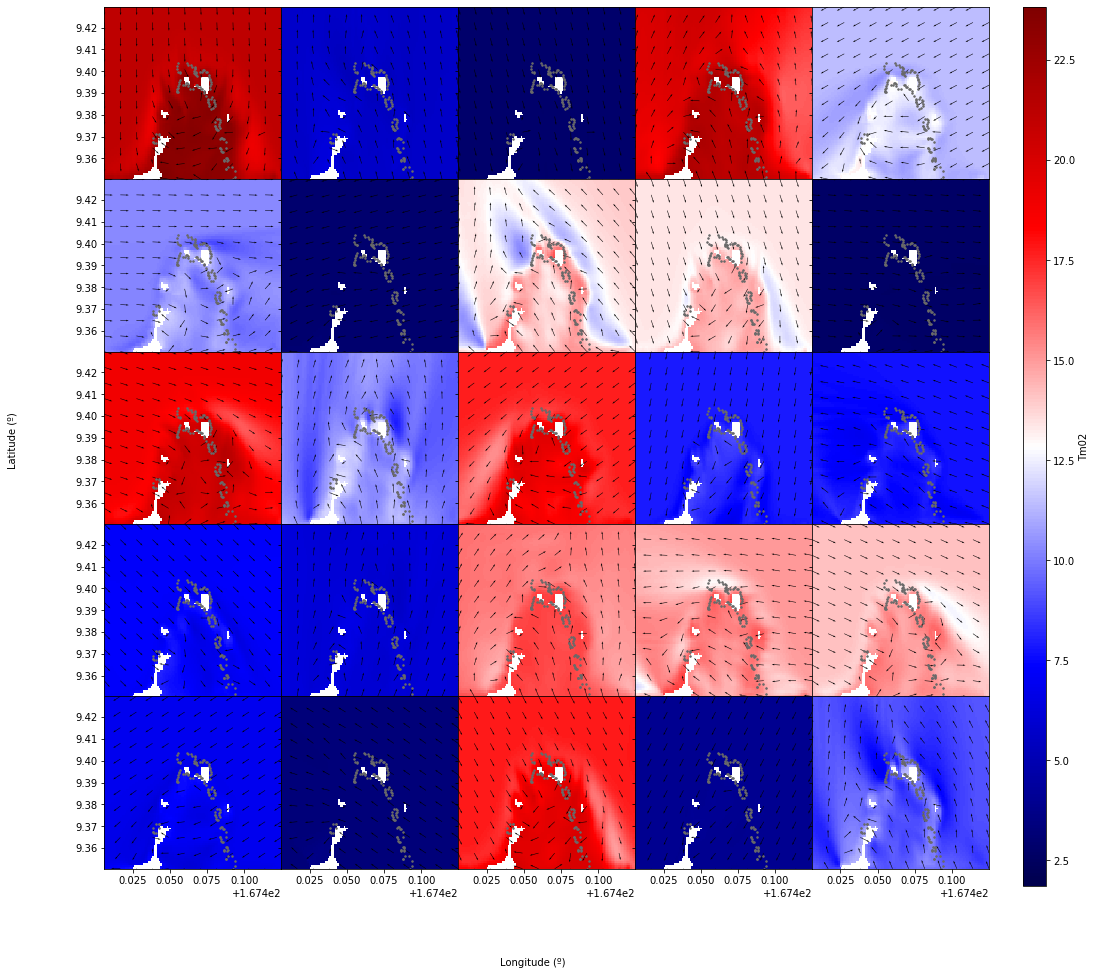

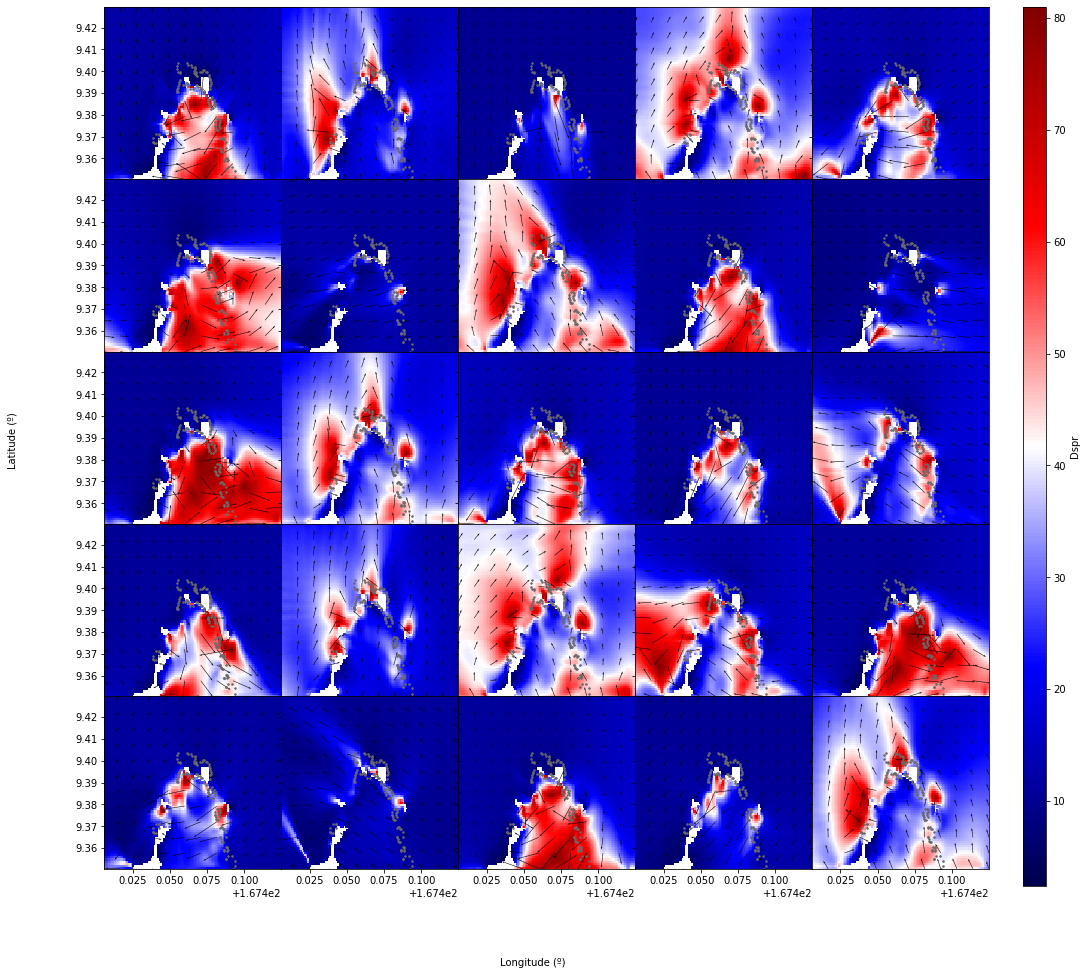

In [9]:
# extract output for nested mesh
out_swl_mn1 = sw.extract_output(mesh=sp.mesh_nest1)
out_swl_mn1.to_netcdf(p_out_swl_mesh_nest1)
print(out_swl_mn1)

# plot scatter maps
scatter_maps(out_swl_mn1, n_cases=25, np_shore=np_shore);



## RBF Reconstruction target: Point SEA and SWELLs propagations

In [10]:
# point to reconstruct 
ix_lon, ix_lat = 62, 66

# Extract output waves at point (from nest1 mesh)
p1_sea = out_sea_mn1.isel({'lon':ix_lon, 'lat':ix_lat}).to_dataframe()
p1_swl = out_swl_mn1.isel({'lon':ix_lon, 'lat':ix_lat}).to_dataframe()

# store data
db.Save_NEARSHORE_TARGET_sea(p1_sea)
db.Save_NEARSHORE_TARGET_swell(p1_swl)
